### Importing libraries

In [1]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import svd, qr
from scipy.fftpack import ifftn, fftn, fftshift
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Functions import anoamly_detection
from main import OptimizingPlacement
from Functions.Optiming_functions import Shannon_nyquist_throrm

In [2]:
placement = OptimizingPlacement()
anomaly_detection = anoamly_detection.AnomalyDetection()
nyquist_throrm = Shannon_nyquist_throrm.NyquistTheorem()

In [3]:
file_name = os.getenv('file_name')
sensor_data = os.getenv("folder_name")
zipped_file = os.getenv("ziped_file")
output_dir = os.getenv('sensor_heatmaps')
video_output = os.getenv('temperature_output')

In [4]:
combined_data, keys_list = placement.extracting_files(zipped_file, sensor_data)

In [5]:
combined_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-05-14 02:18:22,15.25,92.8,047D6,047D6 T/RH IP67
1,2024-05-04 21:21:36,13.95,71,047D6,047D6 T/RH IP67
2,2024-05-04 21:26:37,13.65,71.8,047D6,047D6 T/RH IP67
3,2024-05-04 21:31:35,13.4,72.6,047D6,047D6 T/RH IP67
4,2024-05-04 21:36:36,13.4,73.4,047D6,047D6 T/RH IP67


In [6]:
# placement.heatmap_video_gen(combined_data, output_dir, video_output)

In [7]:
combined_data.isnull().sum()

Time              0
Temperature    9351
Humidity       9351
Sensor ID         0
Sensor Name       0
dtype: int64

In [8]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [9]:
combined_data['Day'] = pd.DatetimeIndex(combined_data['Time']).day
combined_data['Time_Instance'] = pd.DatetimeIndex(combined_data['Time']).time
combined_data['Year'] = pd.DatetimeIndex(combined_data['Time']).year
combined_data['Month'] = pd.DatetimeIndex(combined_data['Time']).month

In [10]:
combined_data['flag'] = combined_data.isna().any(axis=1).astype(int)

In [11]:
final_dataset = placement.replacing_missing_values(combined_data)

Epoch 1/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 7.4703 - val_loss: 6.2107
Epoch 2/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 5.2669 - val_loss: 5.6676
Epoch 3/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 5.1174 - val_loss: 6.3200
Epoch 4/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4.9550 - val_loss: 5.5436
Epoch 5/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4.8502 - val_loss: 4.9987
Epoch 6/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 4.6747 - val_loss: 5.6039
Epoch 7/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4.6465 - val_loss: 4.7434
Epoch 8/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 4.6360 - val_loss: 4.7291
Epoch 9/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 4.5602 - val_loss: 4.9644
Epoch 10/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 4.5063 - val_loss: 4.6175
Epoch 11/20
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 4.4883 - val_loss: 4.9082
Epoch 12/20
8008/80

In [12]:
final_dataset.iloc[1000]

Time             2024-05-07 10:34:40
Temperature                     24.8
Humidity                        51.0
Sensor ID                      047D6
Sensor Name          047D6 T/RH IP67
Day                                7
Time_Instance               10:34:40
Year                            2024
Month                              5
flag                               0
Name: 1000, dtype: object

In [13]:
final_dataset[(final_dataset['Sensor ID'] == '047D6') & (final_dataset['Day'] == 7) & (final_dataset['flag'] == 1)]

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
987,2024-05-07 09:29:43,21.81,60.34,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.22,53.12,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
4528,2024-05-07 15:04:30,27.22,33.77,047D6,047D6 T/RH IP67,7,15:04:30,2024,5,1
4635,2024-05-07 22:59:12,14.10,80.61,047D6,047D6 T/RH IP67,7,22:59:12,2024,5,1


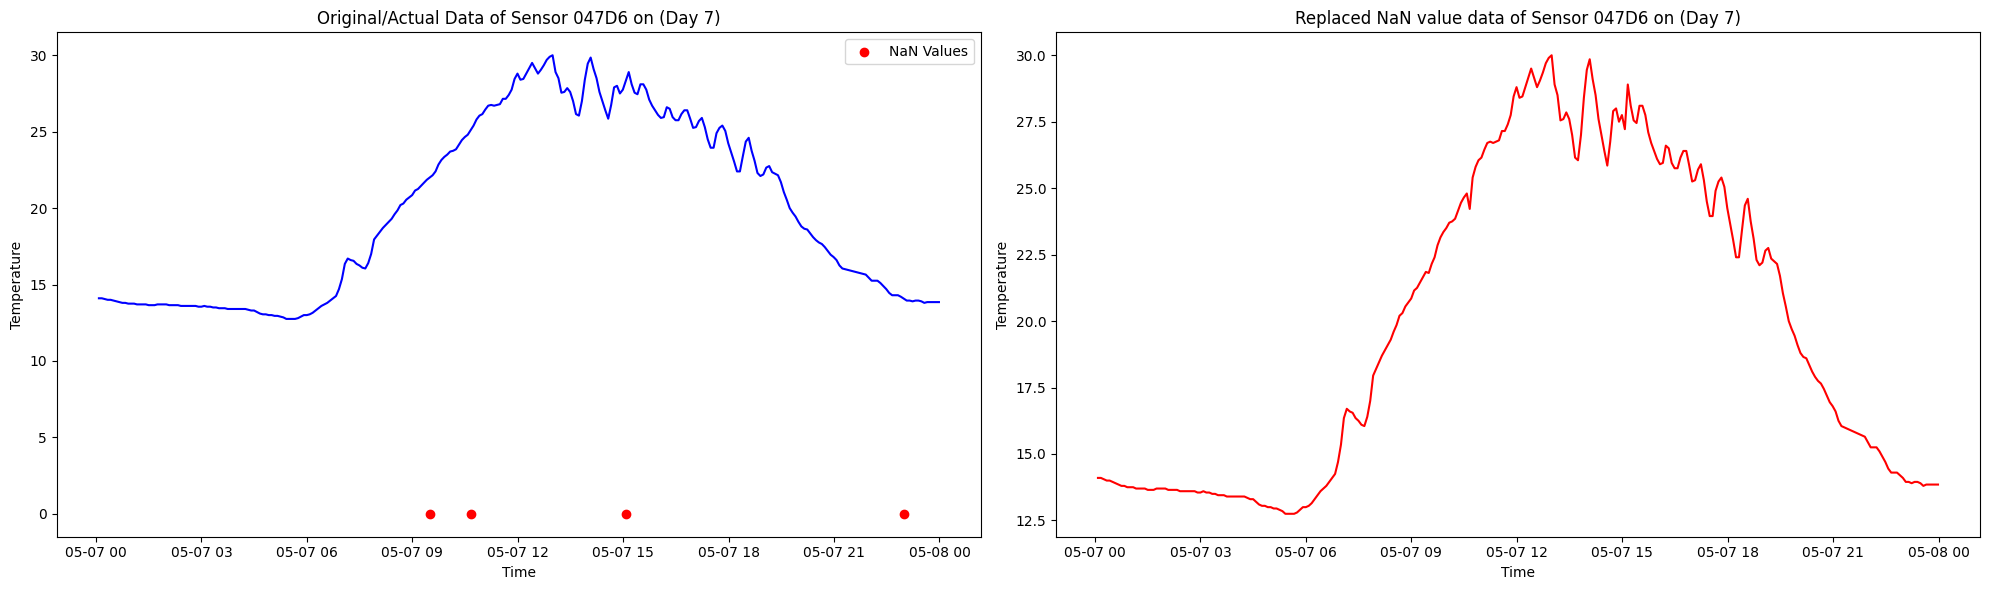

In [14]:
sample_data = combined_data[combined_data['Sensor ID'] == '047D6']
sample_final_data = final_dataset[final_dataset['Sensor ID'] == '047D6']

Non_Empty_data = sample_data[sample_data['Day'] == 7]
final_days = sample_final_data[sample_final_data['Day'] == 7]

Non_Empty_data = Non_Empty_data.sort_values(by='Time')
final_days = final_days.sort_values(by='Time')

# Identify NaN values
nan_indices = Non_Empty_data[Non_Empty_data['Temperature'].isna()].index

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first DataFrame
sns.lineplot(ax=axes[0], x='Time', y='Temperature', data=Non_Empty_data, color='blue')
axes[0].set_title('Original/Actual Data of Sensor 047D6 on (Day 7)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Temperature')

# Highlight NaN values
axes[0].scatter(Non_Empty_data.loc[nan_indices, 'Time'], [0]*len(nan_indices), color='red', marker='o', label='NaN Values')
axes[0].legend()

# Plot the second DataFrame
sns.lineplot(ax=axes[1], x='Time', y='Temperature', data=final_days, color='red')
axes[1].set_title('Replaced NaN value data of Sensor 047D6 on (Day 7)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Temperature')

# Display the plots
plt.tight_layout()
plt.show()

In [15]:
final_dataset[final_dataset['flag'] == 1].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag
358,2024-05-05 05:01:20,8.75,85.33,047D6,047D6 T/RH IP67,5,05:01:20,2024,5,1
851,2024-05-20 08:31:34,13.47,85.45,047D6,047D6 T/RH IP67,20,08:31:34,2024,5,1
987,2024-05-07 09:29:43,21.81,60.34,047D6,047D6 T/RH IP67,7,09:29:43,2024,5,1
1001,2024-05-07 10:39:40,24.22,53.12,047D6,047D6 T/RH IP67,7,10:39:40,2024,5,1
1038,2024-05-20 15:01:20,29.31,46.43,047D6,047D6 T/RH IP67,20,15:01:20,2024,5,1


In [16]:
anomalies_list = []
temperature_color = 'green'
humidity_color = 'blue'

for sensor_id, sensor_data in final_dataset.groupby('Sensor ID'):
    sensor_anomalies = anomaly_detection.detect_anomalies(sensor_data, sensor_id, temperature_color, humidity_color)
    anomalies_list.append(sensor_anomalies)

all_anomalies = pd.concat(anomalies_list)

In [17]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [18]:
mlp_temp = anomaly_detection.training_anomaly_model(X_train_scaled, y_train_temp, '', 'temperature')

Epoch 1/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 10.9271 - val_loss: 8.9063e-04
Epoch 2/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 3/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0016 - val_loss: 3.0628e-05
Epoch 4/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0016 - val_loss: 8.4785e-05
Epoch 5/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0014 - val_loss: 1.4529e-04
Epoch 6/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0016 - val_loss: 3.1916e-05
Epoch 7/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 8.7112e-04 - val_loss: 2.9114e-04
Epoch 8/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0013 - val_loss: 2.0217e-05
Epoch 10/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0011 - val_loss: 3.1070e-06
Epoch 11/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 7.0798e-

In [19]:
mlp_humidity = anomaly_detection.training_anomaly_model(X_train_scaled, '', y_train_humidity, 'humidity')

Epoch 1/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 236.0479 - val_loss: 0.0198
Epoch 2/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 3/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0130 - val_loss: 0.0071
Epoch 4/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0116 - val_loss: 0.0028
Epoch 5/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0141 - val_loss: 2.5862e-04
Epoch 6/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0091 - val_loss: 0.0014
Epoch 7/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0085 - val_loss: 2.8127e-04
Epoch 8/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 9/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0093 - val_loss: 9.7250e-04
Epoch 10/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0129 - val_loss: 2.4288e-04
Epoch 11/20
6164/6164 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0088 - val_loss: 4.0199e-

In [20]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

anomalies.loc[anomalies['Temperature_anomaly'] == 1, 'Temperature'] = 0
anomalies.loc[anomalies['Humidity_anomaly'] == 1, 'Humidity'] = 0

In [21]:
anomalies['Temperature'] = np.round(mlp_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(mlp_humidity.predict(X_anomalies_scaled), 2)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])
final_processed_data = all_anomalies.copy()

# final_anomalies = final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)]

In [23]:
final_processed_data[(final_processed_data['Temperature_anomaly'] == 1) & (final_processed_data['Humidity_anomaly'] == 1)].head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Day,Time_Instance,Year,Month,flag,Temperature_anomaly,Humidity_anomaly
75823,2024-05-20 12:18:36,33.849998,31.410000,0474D,0474D T/RH IP67,20,12:18:36,2024,5,0,1,1
75873,2024-05-20 13:18:34,33.900002,29.520000,0474D,0474D T/RH IP67,20,13:18:34,2024,5,0,1,1
75877,2024-05-20 13:38:33,32.599998,28.639999,0474D,0474D T/RH IP67,20,13:38:33,2024,5,0,1,1
232588,2024-04-30 12:18:06,31.549999,34.000000,04750,04750 T/RH IP67,30,12:18:06,2024,4,0,1,1
232590,2024-04-30 12:28:04,31.600000,34.299999,04750,04750 T/RH IP67,30,12:28:04,2024,4,0,1,1


In [24]:
lastday = final_processed_data['Time'].max().date()
last_day_records = final_processed_data[final_processed_data['Time'].dt.date == lastday]

sensor_sample_data = combined_data[combined_data['Time'].dt.date == lastday]

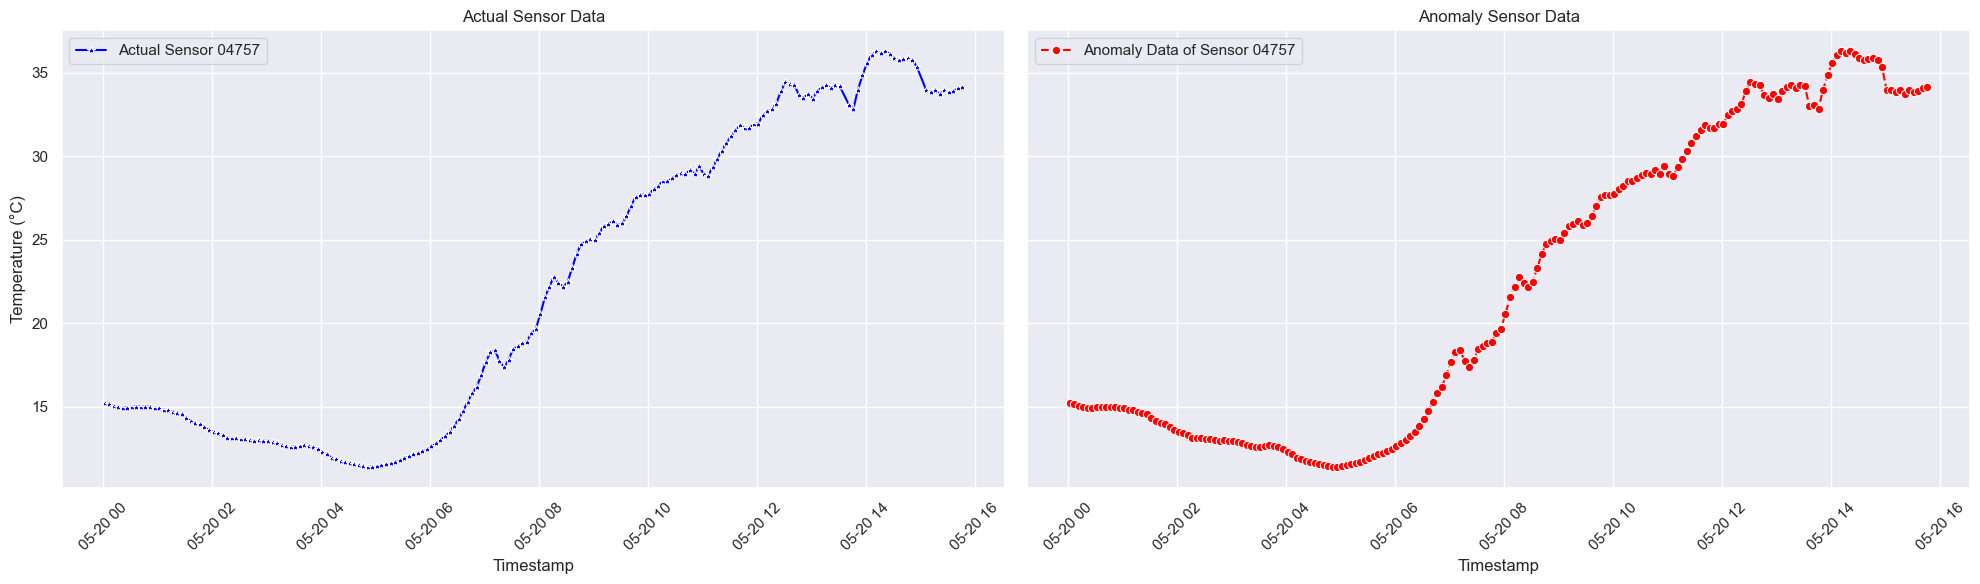

In [25]:
# Set style
sns.set(style="darkgrid")

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Original data
sensor_data = sensor_sample_data[sensor_sample_data['Sensor ID'] == '04757']
sns.lineplot(ax=axs[0], x='Time', y='Temperature', data=sensor_data, 
             marker='*', color='blue',
             label='Actual Sensor 04757')

# Filtered data
filtered_sensor_data = last_day_records[last_day_records['Sensor ID'] == '04757']
sns.lineplot(ax=axs[1], x='Time', y='Temperature', data=filtered_sensor_data, 
             marker='o', color='red',
             linestyle='--', label='Anomaly Data of Sensor 04757')

# Titles and labels
axs[0].set_title('Actual Sensor Data')
axs[1].set_title('Anomaly Sensor Data')

for ax in axs:
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Compare/original_and_filtered_plots_side_by_side.png')
plt.show()

In [26]:
final_processed_data.to_csv('Combined_Data.csv', index=False)

In [27]:
placement.heatmap_video_gen(final_processed_data, output_dir, video_output)

'Successfully generated the heatmap video.'

In [3]:
video_file_path = 'sensor_heatmaps_temperature_video.avi'

In [4]:
# Function to process the video and compute average FFT
def process_video_fft_average(video_path):
    cap = cv2.VideoCapture(video_path)
    frames_processed = 0
    fft_sum = None
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply FFT to the frame using scipy.fftpack.fftn
        f_transform = fftn(gray_frame)
        f_transform_shifted = fftshift(f_transform)
        
        if fft_sum is None:
            fft_sum = np.zeros_like(f_transform_shifted, dtype=np.complex128)
        
        # Accumulate the FFT results
        fft_sum += f_transform_shifted
        frames_processed += 1
    
    cap.release()
    
    # Calculate the average FFT
    fft_avg = fft_sum / frames_processed
    
    # Compute magnitude spectrum
    magnitude_spectrum = 20 * np.log(np.abs(fft_avg))
    
    return fft_avg, magnitude_spectrum

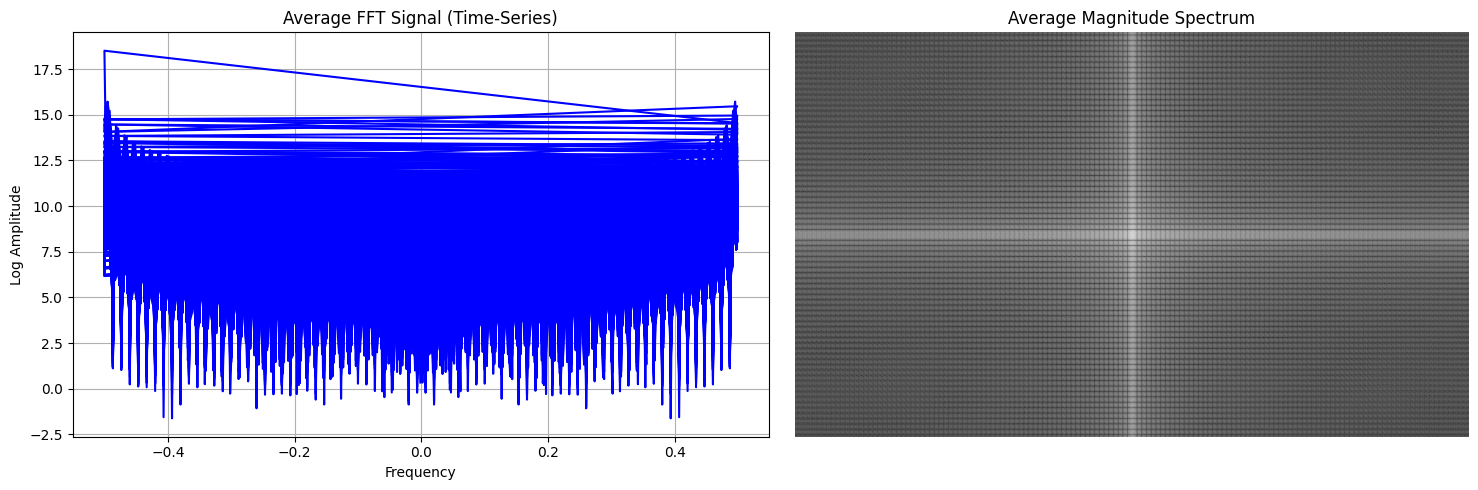

In [5]:
# Process the video and compute average FFT
fft_avg, magnitude_spectrum_avg = process_video_fft_average(video_file_path)

# Plot the average FFT signal and its magnitude spectrum
plt.figure(figsize=(15, 5))

# Compute the frequency values for the x-axis
freq_values = np.fft.fftfreq(fft_avg.shape[0])

plt.subplot(1, 2, 1)
plt.plot(freq_values, np.log(np.abs(fft_avg)), color='b')
plt.title('Average FFT Signal (Time-Series)')
plt.xlabel('Frequency')
plt.ylabel('Log Amplitude')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum_avg, cmap='gray')
plt.title('Average Magnitude Spectrum')
plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
frame_count, width, height = nyquist_throrm.get_video_info(video_file_path)
video_data = nyquist_throrm.read_video_file(video_file_path)
results_step_1 = nyquist_throrm.reading_video(frame_count, width, height, video_data)

In [7]:
frame_count, width, height

(891, 1000, 600)

In [8]:
video_data

array([[[162, 162, 162, ..., 231, 231, 231],
        [162, 162, 162, ..., 231, 231, 231],
        [162, 162, 162, ..., 231, 231, 231],
        ...,
        [243, 243, 243, ...,  87,  87,  87],
        [243, 243, 243, ...,  87,  87,  87],
        [243, 243, 243, ...,  87,  87,  87]],

       [[163, 163, 163, ..., 231, 231, 231],
        [163, 163, 163, ..., 231, 231, 231],
        [163, 163, 163, ..., 231, 231, 231],
        ...,
        [243, 243, 243, ..., 104, 104, 104],
        [243, 243, 243, ..., 104, 104, 104],
        [243, 243, 243, ..., 104, 104, 104]],

       [[163, 163, 163, ..., 231, 231, 231],
        [163, 163, 163, ..., 231, 231, 231],
        [163, 163, 163, ..., 231, 231, 231],
        ...,
        [242, 242, 242, ..., 122, 122, 122],
        [242, 242, 242, ..., 122, 122, 122],
        [242, 242, 242, ..., 122, 122, 122]],

       ...,

       [[155, 155, 155, ..., 221, 221, 221],
        [155, 155, 155, ..., 221, 221, 221],
        [155, 155, 155, ..., 221, 221, 221

In [9]:
results_step_1['fft_data']

array([[[ 9.75739208e+10-0.00000000e+00j,
          1.11981418e+09-2.36786845e+08j,
          9.45963031e+08-2.06857097e+09j, ...,
         -2.06386175e+09-9.86133794e+08j,
          9.45963031e+08+2.06857097e+09j,
          1.11981418e+09+2.36786845e+08j],
        [-5.47232211e+08-1.77544644e+09j,
         -4.66141458e+09-1.96801789e+07j,
         -1.18787251e+07-1.83397571e+09j, ...,
         -1.78001490e+09-3.07222535e+08j,
          2.70262290e+09-7.33595540e+08j,
          2.18448742e+09-7.77096367e+08j],
        [ 1.50114722e+09+1.18459498e+09j,
          4.18810857e+09-1.06720485e+09j,
         -1.34405319e+08+2.14507532e+09j, ...,
         -9.21327203e+06+7.09150498e+08j,
          1.21318780e+09+1.26630988e+09j,
         -1.50757975e+09+8.54888103e+08j],
        ...,
        [-6.21257969e+08+5.97884285e+09j,
         -1.58513646e+09-4.22720273e+09j,
         -1.81311776e+09+2.67635543e+08j, ...,
          3.37719680e+09+6.98631132e+08j,
          2.29341961e+09-2.91378609e+09j

In [10]:
results_step_1['magnitude_spectrum']

array([[[9.75739208e+10, 1.14457495e+09, 2.27460588e+09, ...,
         2.28735332e+09, 2.27460588e+09, 1.14457495e+09],
        [1.85786790e+09, 4.66145612e+09, 1.83401418e+09, ...,
         1.80633295e+09, 2.80041657e+09, 2.31859097e+09],
        [1.91225214e+09, 4.32194164e+09, 2.14928196e+09, ...,
         7.09210345e+08, 1.75367196e+09, 1.73309849e+09],
        ...,
        [6.01103346e+09, 4.51463183e+09, 1.83276424e+09, ...,
         3.44870174e+09, 3.70808885e+09, 3.71766039e+09],
        [1.91225214e+09, 1.73309849e+09, 1.75367196e+09, ...,
         2.88060509e+09, 2.14928196e+09, 4.32194164e+09],
        [1.85786790e+09, 2.31859097e+09, 2.80041657e+09, ...,
         1.29384658e+09, 1.83401418e+09, 4.66145612e+09]],

       [[1.32998870e+09, 1.33402125e+09, 1.05002016e+09, ...,
         8.27530309e+08, 8.44315548e+08, 1.11836630e+09],
        [4.23563983e+08, 9.02951058e+08, 2.01976275e+09, ...,
         2.82001991e+08, 6.67070959e+08, 6.10585256e+08],
        [2.71531933e+08, 

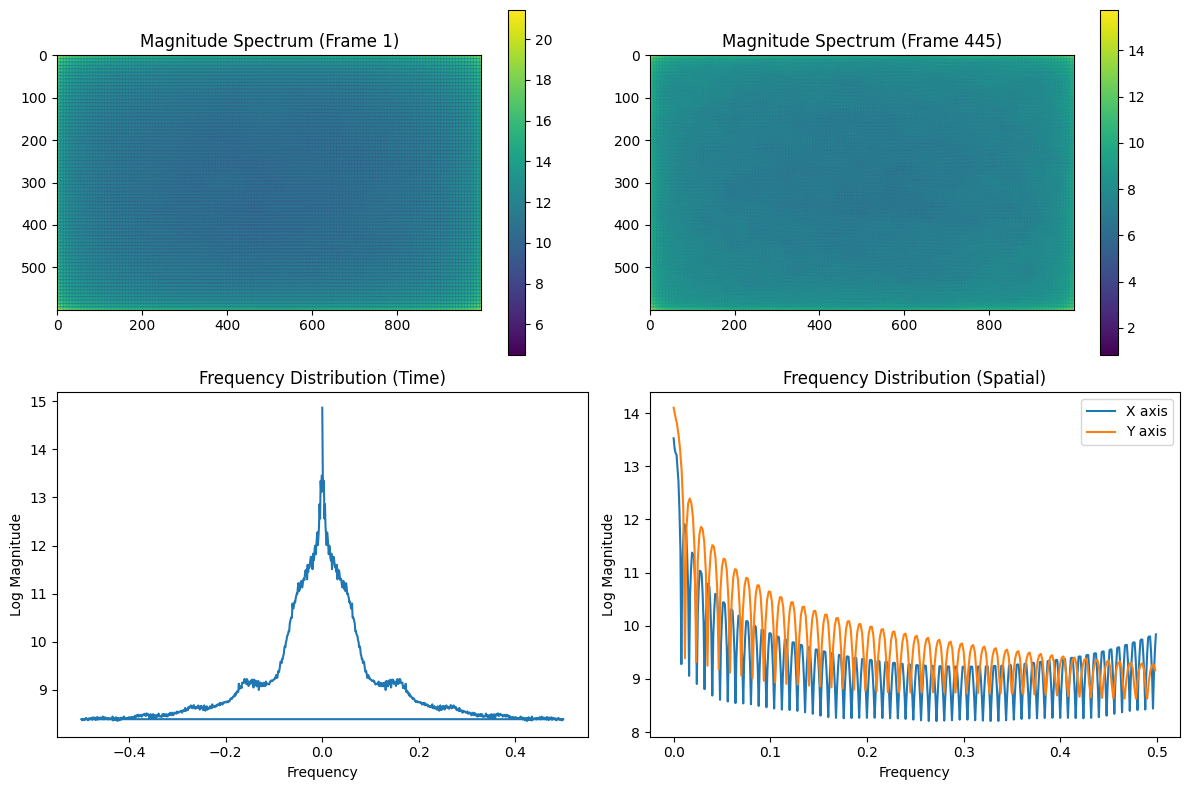

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(np.log1p(results_step_1['magnitude_spectrum'][1]), cmap='viridis')
plt.title("Magnitude Spectrum (Frame 1)")
plt.colorbar()

middle_frame = frame_count // 2
plt.subplot(2, 2, 2)
plt.imshow(np.log1p(results_step_1['magnitude_spectrum'][middle_frame]), cmap='viridis')
plt.title(f"Magnitude Spectrum (Frame {middle_frame})")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.plot(results_step_1['frequencies_time'], np.log1p(np.mean(results_step_1['magnitude_spectrum'], axis=(1, 2))))
plt.title("Frequency Distribution (Time)")
plt.xlabel("Frequency")
plt.ylabel("Log Magnitude")

plt.subplot(2, 2, 4)
plt.plot(results_step_1['frequencies_x'][:width//2], np.log1p(np.mean(results_step_1['magnitude_spectrum'], axis=(0, 2))[:width//2]), label='X axis')
plt.plot(results_step_1['frequencies_y'][:height//2], np.log1p(np.mean(results_step_1['magnitude_spectrum'], axis=(0, 1))[:height//2]), label='Y axis')
plt.title("Frequency Distribution (Spatial)")
plt.xlabel("Frequency")
plt.ylabel("Log Magnitude")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Load sensor placement data
with open('sensor_placement.json', 'r') as file:
    sensor_placement = json.load(file)

In [13]:
# Convert lists to tuples and create reverse lookup dictionary
sensor_reverse_lookup = {tuple(v): k for k, v in sensor_placement.items()}

In [14]:
# Assuming fft_data is loaded from results_step_1["fft_data"]
fft_data = results_step_1["fft_data"]

In [15]:
# Check the shape of fft_data
print(f"fft_data shape: {fft_data.shape}")

data_matrix = np.reshape(fft_data, (fft_data.shape[0], -1))

# Verify the reshaped data matrix
print(f"data_matrix shape: {data_matrix.shape}")

fft_data shape: (891, 600, 1000)
data_matrix shape: (891, 600000)


In [16]:
data_matrix

array([[ 9.75739208e+10-0.00000000e+00j,  1.11981418e+09-2.36786845e+08j,
         9.45963031e+08-2.06857097e+09j, ...,
        -6.34903930e+08+1.12735796e+09j, -1.18787251e+07+1.83397571e+09j,
        -4.66141458e+09+1.96801789e+07j],
       [-9.94587194e+08+8.82987128e+08j,  1.28128776e+09-3.71368239e+08j,
        -9.84269327e+08-3.65726998e+08j, ...,
        -4.21674775e+08-2.06946995e+08j,  5.29687242e+08-3.25542385e+08j,
         1.77684248e+08+1.27524578e+09j],
       [-3.32365373e+06-5.45784966e+08j, -1.22017910e+08+2.03282699e+08j,
        -1.17545661e+08+5.24862724e+08j, ...,
        -1.07903605e+08+6.42191322e+08j,  5.31937359e+07+3.81964246e+08j,
         1.73250044e+08-3.33801880e+08j],
       ...,
       [ 1.76326868e+09+2.21297930e+08j, -1.03550614e+09+2.20509476e+08j,
         1.07729518e+09-4.33885108e+08j, ...,
         1.21735046e+08+5.74299930e+07j, -1.00588100e+09-7.77806744e+07j,
         4.75314435e+08-1.05598034e+09j],
       [-3.32365373e+06+5.45784966e+08j,  1.

In [17]:
# Apply Proper Orthogonal Decomposition (POD) using SVD
U, S, Vt = svd(data_matrix, full_matrices=False)

In [18]:
S

array([1.01693269e+11, 1.15386449e+10, 9.33046269e+09, 8.18419686e+09,
       4.40457881e+09, 4.26397335e+09, 4.01770397e+09, 3.85505714e+09,
       3.53244439e+09, 3.13999692e+09, 3.05535328e+09, 2.87190221e+09,
       2.47635534e+09, 2.43068890e+09, 2.27508155e+09, 2.08167524e+09,
       1.98626241e+09, 1.92725479e+09, 1.87422270e+09, 1.71712247e+09,
       1.57955617e+09, 1.56141852e+09, 1.48349116e+09, 1.44455670e+09,
       1.38399518e+09, 1.26220999e+09, 1.22208541e+09, 1.16258135e+09,
       1.06462466e+09, 1.03427823e+09, 9.81412122e+08, 9.39265988e+08,
       8.65613482e+08, 8.26337324e+08, 7.48916001e+08, 7.31078942e+08,
       7.06820152e+08, 6.82035873e+08, 6.65462681e+08, 6.05989661e+08,
       5.88094332e+08, 5.55150973e+08, 4.94141186e+08, 4.63792069e+08,
       4.48351913e+08, 3.90446313e+08, 3.55032596e+08, 3.20989933e+08,
       2.69750817e+08, 2.31127537e+08, 2.22784578e+08, 1.84534087e+08,
       1.68326336e+08, 1.55176896e+08, 1.22404008e+08, 9.49837650e+07,
      

In [19]:
U

array([[-9.99339351e-01-1.27054942e-21j, -2.72121521e-02+1.04083409e-17j,
         2.29795089e-03+4.17417836e-17j, ...,
        -5.42135190e-06+5.99936496e-17j,  2.03532886e-05-1.31307047e-17j,
        -6.15945088e-05-1.31861854e-18j],
       [ 1.02724298e-02-5.23706114e-03j, -4.24614457e-01-1.01569083e-01j,
         2.92139250e-02-5.26943233e-01j, ...,
         4.66085000e-04+4.73753244e-04j, -4.46581243e-04+4.83240757e-06j,
        -5.40248306e-04+8.48070703e-04j],
       [-1.54688546e-03+5.00167239e-03j,  1.05303767e-01+4.83867038e-02j,
        -6.35595757e-02-4.31496107e-02j, ...,
         1.79031030e-04+1.16719389e-03j, -5.25930104e-04+2.85157429e-04j,
        -2.92312185e-04-3.46516796e-04j],
       ...,
       [-1.58058795e-02-2.85767326e-03j,  4.72026996e-01-3.17004975e-02j,
        -3.31599194e-02+3.42858010e-01j, ...,
         1.17141754e-03+2.51568883e-04j,  1.97306836e-04+3.29610419e-04j,
         3.80871042e-04+5.10985412e-04j],
       [-1.54688546e-03-5.00167239e-03j,  1.

In [20]:
# Calculate cumulative explained variance
explained_variance = np.cumsum(S) / np.sum(S)

In [21]:
explained_variance

array([0.48784625, 0.54319981, 0.58796021, 0.62722171, 0.6483515 ,
       0.66880677, 0.68808063, 0.70657423, 0.72352019, 0.73858349,
       0.75324073, 0.76701791, 0.77889756, 0.79055814, 0.80147224,
       0.81145852, 0.82098708, 0.83023257, 0.83922365, 0.84746109,
       0.85503858, 0.86252907, 0.86964572, 0.8765756 , 0.88321494,
       0.88927006, 0.89513269, 0.90070986, 0.90581711, 0.91077879,
       0.91548685, 0.91999272, 0.92414527, 0.92810941, 0.93170213,
       0.93520929, 0.93860007, 0.94187195, 0.94506433, 0.9479714 ,
       0.95079263, 0.95345582, 0.95582633, 0.95805125, 0.96020209,
       0.96207516, 0.96377833, 0.96531819, 0.96661225, 0.96772102,
       0.96878977, 0.96967503, 0.97048253, 0.97122695, 0.97181415,
       0.97226981, 0.97244092, 0.9726052 , 0.97276752, 0.97292135,
       0.97307318, 0.97322097, 0.97336476, 0.97350531, 0.97364187,
       0.97377496, 0.97390687, 0.97403285, 0.97415521, 0.97427564,
       0.97439467, 0.97451231, 0.97462663, 0.97473991, 0.97485

In [22]:
# Determine the number of modes needed to reach the desired explained variance
desired_variance = 0.925 # 90% explained variance
num_modes = np.searchsorted(explained_variance, desired_variance) + 1

In [23]:
num_modes

34

In [24]:
# Select a subset of modes
reduced_data = U[:, :num_modes] @ np.diag(S[:num_modes])

In [25]:
reduced_data.shape

(891, 34)

In [26]:
# Perform QR decomposition with column pivoting on reduced data
Q, R, P = qr(reduced_data.T, pivoting=True)

In [27]:
num_sensors = num_modes

In [28]:
selected_sensors_indices = P[:num_sensors]

In [29]:
selected_sensors = []
grid_rows, grid_cols = 8, 7
grid_size = grid_rows * grid_cols

for idx in selected_sensors_indices:
    rem = idx % grid_size
    x, y = divmod(rem, grid_cols)
    sensor_id = sensor_reverse_lookup.get((grid_rows - x, y + 1))
    selected_sensors.append([grid_rows - x, y + 1])

print("Selected sensor locations (row, column):", selected_sensors)

Selected sensor locations (row, column): [[8, 1], [1, 2], [8, 2], [8, 3], [1, 1], [8, 4], [2, 7], [8, 6], [2, 6], [8, 5], [2, 5], [2, 4], [8, 7], [2, 3], [7, 1], [7, 3], [7, 5], [2, 1], [3, 6], [3, 3], [2, 2], [7, 2], [6, 1], [3, 4], [7, 7], [7, 6], [3, 5], [6, 3], [5, 1], [4, 2], [4, 4], [4, 1], [5, 6], [6, 7]]


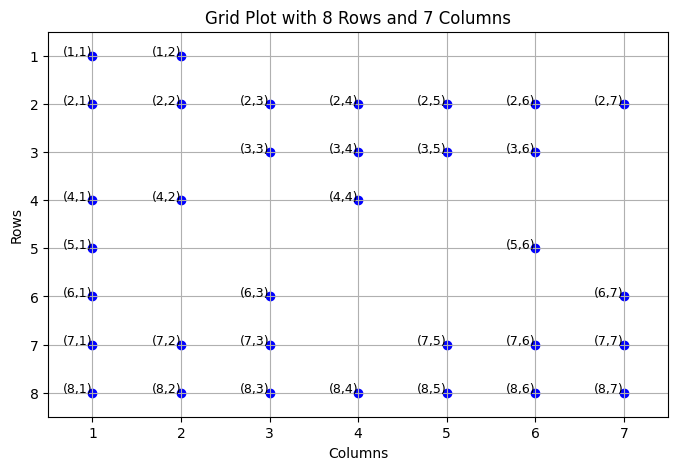

In [30]:
# Create a grid plot
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.xticks(range(1, 8))  # X-axis ticks for columns (1 to 7)
plt.yticks(range(1, 9))  # Y-axis ticks for rows (1 to 8)
plt.xlim(0.5, 7.5)
plt.ylim(0.5, 8.5)

# Plot each point
for (row, col) in selected_sensors:
    plt.scatter(col, row, c='blue')  # Use (column, row) for plotting
    plt.text(col, row, f'({row},{col})', fontsize=9, ha='right')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to match typical grid layout
plt.title("Grid Plot with 8 Rows and 7 Columns")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [31]:
with open('sensor_placement.json','r') as sensor:
    data = json.load(sensor)

In [32]:
selected_sensors_list = [key for key, value in data.items() if value in selected_sensors]

In [33]:
reduced_sensor_data = pd.read_csv('Combined_Data.csv')

In [34]:
reduced_sensor_data = reduced_sensor_data[reduced_sensor_data['Sensor ID'].isin(selected_sensors_list)]

In [35]:
reduced_sensor_data['Sensor ID'].unique()

array(['0474D', '04754', '04756', '04757', '0475A', '0475C', '0475D',
       '04768', '0476E', '04771', '04787', '0478A', '0478C', '0478E',
       '0479B', '0479E', '047A8', '047AA', '047AD', '047B2', '047B6',
       '047B8', '047BB', '047BC', '047C1', '047C9', '047CA', '047CB',
       '047CE', '047D3', '047D4', '047D6', '047F7', '04804'], dtype=object)

In [36]:
reduced_sensor_data['Sensor ID'] = pd.Categorical(reduced_sensor_data['Sensor ID'], categories=selected_sensors_list, ordered=True)
reduced_df_sorted = reduced_sensor_data.sort_values(by='Sensor ID')
reduced_df_sorted = reduced_df_sorted[~pd.isna(reduced_df_sorted['Sensor ID'])]
reduced_df_sorted['Sensor ID'] = reduced_df_sorted['Sensor ID'].astype(str)
reduced_df_sorted.reset_index(drop=True, inplace=True)

In [51]:
from scipy.ndimage import gaussian_filter
import shutil

output_dir = 'reconstructed_heatmaps'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir)

frames = []
for i in range(1, 101):
    temp_dataset = reduced_df_sorted.groupby('Sensor ID').nth(i - 1).reset_index()

    # Prepare the matrix
    rows, cols = 8, 7
    sensor_matrix = np.zeros((rows, cols), dtype=float)  # Assuming temperature is a float

    # Populate the matrix
    for sensor_id, (row, col) in data.items():
        if sensor_id in temp_dataset['Sensor ID'].astype(str).values:
            temp_value = temp_dataset[temp_dataset['Sensor ID'].astype(str) == sensor_id]['Temperature'].values
            if len(temp_value) > 0:
                sensor_matrix[rows - row, col - 1] = temp_value[0]

    # Apply Gaussian filter
    sigma = 2  # Standard deviation for Gaussian kernel
    smoothed_data = gaussian_filter(sensor_matrix, sigma=sigma, mode='nearest')

    # Replace zeros with smoothed values
    filled_data = np.where(sensor_matrix == 0, smoothed_data, sensor_matrix)

    plt.figure(figsize=(10, 6))
    sns.heatmap(filled_data, annot=False, cmap="YlGnBu", fmt=".2f", cbar=False, xticklabels=False, yticklabels=False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    output_file = os.path.join(output_dir, f"heatmap_{i}.png")
    plt.savefig(output_file)
    plt.close()

    frames.append(output_file)

In [52]:
frame = cv2.imread(frames[0])
height, width, _ = frame.shape

video_output = 'reconstructed_heatmapvideo.avi'

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter(video_output, fourcc, 24.0, (width, height))

prev_frame = cv2.imread(frames[0])

for frame_path in frames[1:]:
    next_frame = cv2.imread(frame_path)
    
    for i in range(1, 10):
        alpha = i / 10.0
        interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
        video.write(interpolated_frame)

    prev_frame = next_frame

video.release()
cv2.destroyAllWindows()

print(f"Video saved as: {video_output}")

Video saved as: reconstructed_heatmapvideo.avi


In [53]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy import stats

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def compare_frames(frame1, frame2):
    frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    score, _ = ssim(frame1_gray, frame2_gray, full=True)
    return score

def compare_videos(video1_frames, video2_frames):
    if len(video1_frames) != len(video2_frames):
        print("Videos have different number of frames")
    
    similarity_scores = []
    for f1, f2 in zip(video1_frames, video2_frames):
        score = compare_frames(f1, f2)
        similarity_scores.append(score)
    
    return similarity_scores

def overall_similarity(similarity_scores):
    return np.mean(similarity_scores)

def perform_statistical_tests(similarity_scores):
    # Perform a one-sample t-test on similarity scores
    t_statistic, p_value_ttest = stats.ttest_1samp(similarity_scores, 0)
    
    # Perform a Wilcoxon signed-rank test
    w_statistic, p_value_wilcoxon = stats.wilcoxon(similarity_scores - np.mean(similarity_scores))
    
    # Perform a Kolmogorov-Smirnov test
    d_statistic, p_value_ks = stats.kstest(similarity_scores, 'norm', args=(np.mean(similarity_scores), np.std(similarity_scores)))
    
    return {
        't-test': (t_statistic, p_value_ttest),
        'Wilcoxon signed-rank test': (w_statistic, p_value_wilcoxon),
        'Kolmogorov-Smirnov test': (d_statistic, p_value_ks)
    }

# Paths to your video files
video1_path = 'reconstructed_heatmapvideo.avi'
video2_path = 'sensor_heatmaps_temperature_video.avi'

# Extract frames
video1_frames = extract_frames(video1_path)
video2_frames = extract_frames(video2_path)

# Compare videos
similarity_scores = compare_videos(video1_frames, video2_frames)

# Compute overall similarity
overall_score = overall_similarity(similarity_scores)

# Perform statistical tests
statistical_results = perform_statistical_tests(similarity_scores)

print(f"Overall similarity score: {overall_score}")
print(f"T-test: T-statistic = {statistical_results['t-test'][0]}, P-value = {statistical_results['t-test'][1]}")
print(f"Wilcoxon signed-rank test: Statistic = {statistical_results['Wilcoxon signed-rank test'][0]}, P-value = {statistical_results['Wilcoxon signed-rank test'][1]}")
print(f"Kolmogorov-Smirnov test: Statistic = {statistical_results['Kolmogorov-Smirnov test'][0]}, P-value = {statistical_results['Kolmogorov-Smirnov test'][1]}")


Overall similarity score: 0.7371899566592957
T-test: T-statistic = 915.2185945996412, P-value = 0.0
Wilcoxon signed-rank test: Statistic = 193577.0, P-value = 0.5055434382807307
Kolmogorov-Smirnov test: Statistic = 0.05472819286073599, P-value = 0.009251264709608862
